In [28]:
#Importación de librerias

import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df_prob = pd.read_csv('../data/prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv')
df_master = pd.read_csv('../data/prueba_op_master_customer_data_enmascarado_completa.csv')
df_cuotas = pd.read_csv('../data/prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv')
df_test = pd.read_csv('../data/prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv')

In [3]:
#Cambios de tipo de variable

#Df_prob
df_prob['fecha_corte'] = pd.to_datetime(df_prob['fecha_corte'].astype(str), format='%Y%m', errors='coerce')


#Df_master
cols_to_convert = ['ano_nac_cli', 'edad_cli', 'num_hijos', 'personas_dependientes']

# Convertir cada columna a numérico y luego a int, imputando 0 para los NaN
for col in cols_to_convert:
    # Convertir a numérico (por si acaso hay valores que no sean numéricos)
    df_master[col] = pd.to_numeric(df_master[col], errors='coerce')
    # Imputar NaN con 0 (o el valor que consideres adecuado) y convertir a int
    df_master[col] = df_master[col].fillna(0).astype(int)

# Verifica la conversión mostrando los tipos de datos
print(df_master[cols_to_convert].dtypes)

# Variables a Fechas
df_master['f_vinc'] = pd.to_datetime(df_master['f_vinc'], format='%Y%m%d', errors='coerce')
df_master['f_ult_mantenimiento'] = pd.to_datetime(df_master['f_ult_mantenimiento'], format='%Y%m%d', errors='coerce')

#Df_cuotas
df_cuotas['fecha_corte'] = pd.to_datetime(df_cuotas['fecha_corte'], format='%Y%m%d', errors='coerce')
df_cuotas['fecha_pago_minima'] = pd.to_datetime(df_cuotas['fecha_pago_minima'], format='%Y%m%d', errors='coerce')
df_cuotas['fecha_pago_maxima'] = pd.to_datetime(df_cuotas['fecha_pago_maxima'], format='%Y%m%d', errors='coerce')






ano_nac_cli              int64
edad_cli                 int64
num_hijos                int64
personas_dependientes    int64
dtype: object


In [4]:
dataset = df_test[['nit_enmascarado', 'num_oblig_enmascarado', 'num_oblig_orig_enmascarado','var_rpta_alt','fecha_var_rpta_alt']]


In [5]:

# -----------------------------
# 2. Merge con la base de cuotas
# -----------------------------
df_cuotas = df_cuotas[['nit_enmascarado', 'num_oblig_enmascarado', 'fecha_corte','producto','aplicativo','segmento','valor_cuota_mes','pago_total','marca_pago']]
df_cuotas['fecha_corte'] = pd.to_datetime(df_cuotas['fecha_corte'], format='%Y%m%d', errors='coerce')

dataset = pd.merge(dataset, df_cuotas, how='left', on=['nit_enmascarado', 'num_oblig_enmascarado'])
dataset['fecha_var_rpta_alt'] = pd.to_datetime(dataset['fecha_var_rpta_alt'], format='%Y%m', errors='coerce')
dataset = dataset[dataset['fecha_corte'] < dataset['fecha_var_rpta_alt']]




In [6]:


def clasificar_marca_pago(row):
    total = row['valor_cuota_mes']
    pago = row['pago_total']
    
    # Si el valor total es 0, sin importar el pago, se clasifica como "cancelado"
    if total == 0:
        return 'cancelado'
    else:
        # Si hay un valor total (diferente de 0):
        if pago == 0:
            return 'no pago'
        elif pago > total:
            return 'paga mas'
        elif pago < total:
            return 'paga menos'
        elif pago == total:
            return 'pago full'
        else:
            return ''

# Aplicar la función a cada fila de dataset
dataset['marca_pago2'] = dataset.apply(clasificar_marca_pago, axis=1)



# --- Paso 1: Ordenar por fechas ---
dataset = dataset.sort_values(['nit_enmascarado', 'num_oblig_enmascarado', 'fecha_corte'])

# --- Paso 2: Calcular el ratio de pago (para referencia, luego se descarta) ---
dataset['ratio_pago'] = dataset['pago_total'] / dataset['valor_cuota_mes']
dataset['ratio_pago'] = dataset['ratio_pago'].fillna(0)





In [7]:
# --- Paso 3: Seleccionar los últimos 6 registros para cada obligación ---
df_last6 = dataset.groupby(['nit_enmascarado', 'num_oblig_enmascarado','fecha_var_rpta_alt'], as_index=False).tail(6)

# --- Paso 4: Crear la variable binaria a partir de 'marca_pago2' ---
def binarizar_pago(marca):
    # Convertir a minúsculas para evitar problemas de mayúsculas/minúsculas
    if isinstance(marca, str) and marca.lower() in ['pago full', 'paga mas']:
        return 1
    else:
        return 0

df_last6['pago_binario'] = df_last6['marca_pago2'].apply(binarizar_pago)

C:\Users\alejreye\AppData\Local\Temp\ipykernel_30756\3741707274.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last6['pago_binario'] = df_last6['marca_pago2'].apply(binarizar_pago)


In [8]:
distinct_oblig = dataset.drop_duplicates(subset=['num_oblig_enmascarado', 'nit_enmascarado','fecha_var_rpta_alt']).shape[0]
print("Número de combinaciones únicas de obligación y nit:", distinct_oblig)

Número de combinaciones únicas de obligación y nit: 567214


In [9]:

# Calcular el promedio del indicador binario en los últimos 6 registros para cada obligación
agg_binario = df_last6.groupby(['nit_enmascarado', 'num_oblig_enmascarado'], as_index=False)['pago_binario'].mean()
agg_binario.rename(columns={'pago_binario': 'promedio_pago_6m'}, inplace=True)

# --- Paso 5: Calcular el conteo de ocurrencias de cada categoría en 'marca_pago2' para los últimos 6 registros ---
marca_pago_counts = df_last6.groupby(
    ['nit_enmascarado', 'num_oblig_enmascarado']
)['marca_pago2'].value_counts().unstack(fill_value=0).reset_index()

# Renombrar columnas (las dos primeras son las llaves, el resto son las categorías)
cols = marca_pago_counts.columns.tolist()
new_cols = cols[:2] + [f'count_{col}' for col in cols[2:]]
marca_pago_counts.columns = new_cols

# --- Paso 6: Fusionar las métricas históricas con el DataFrame original ---
# Primero, fusionar el promedio binario (promedio_pago_6m)
dataset = pd.merge(
    dataset,
    agg_binario,
    on=['nit_enmascarado', 'num_oblig_enmascarado'],
    how='left'
)


In [10]:

# Luego, fusionar los conteos de 'marca_pago2'
dataset = pd.merge(
    dataset,
    marca_pago_counts,
    on=['nit_enmascarado', 'num_oblig_enmascarado'],
    how='left'
)



In [11]:
# --- Paso 7: Eliminar columnas que ya no se requieren ---
dataset = dataset.drop(columns=['valor_cuota_mes', 'pago_total', 'marca_pago', 'marca_pago2', 'ratio_pago'])

# --- Paso 8: Ordenar por 'nit_enmascarado' y 'fecha_corte' (descendente) y conservar el registro más reciente por cliente ---
dataset = dataset.sort_values(['nit_enmascarado', 'fecha_corte'], ascending=[True, False])

In [12]:


dataset = dataset.drop_duplicates(subset=['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_alt'], keep='first')

In [13]:
dataset=dataset.drop(columns=['fecha_corte'])

In [14]:
#Analisis de df_prob
df_prob['prob_alrt_temprana'] = pd.to_numeric(df_prob['prob_alrt_temprana'], errors='coerce')
df_prob['prob_auto_cura'] = pd.to_numeric(df_prob['prob_auto_cura'], errors='coerce')
df_prob['prob_propension'] = pd.to_numeric(df_prob['prob_propension'], errors='coerce')
dataset = pd.merge(dataset, df_prob, how='left', on=['nit_enmascarado', 'num_oblig_enmascarado'])
dataset = dataset[dataset['fecha_var_rpta_alt'] > dataset['fecha_corte']]

In [15]:
dataset = dataset.sort_values(['nit_enmascarado', 'fecha_corte'], ascending=[True, False])
dataset = dataset.drop_duplicates(subset=['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_alt'], keep='first')

In [16]:
dataset = pd.get_dummies(dataset, columns=['producto','aplicativo', 'segmento'], drop_first=True)

In [17]:
dataset=dataset.drop(columns=['fecha_corte','fecha_var_rpta_alt'])

In [19]:
conteo_variable_respuesta = dataset['var_rpta_alt'].value_counts()
print(conteo_variable_respuesta)

var_rpta_alt
0    294212
1    272189
Name: count, dtype: int64


In [20]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Definir las columnas identificadoras y la variable objetivo
id_columns = ['nit_enmascarado', 'num_oblig_enmascarado', 'num_oblig_orig_enmascarado']
target_column = 'var_rpta_alt'

# Separar las características y la variable objetivo
X = dataset.drop(columns=id_columns + [target_column])
y = dataset[target_column]

In [21]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
    
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

c:\Program Files\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6575771753427317
F1 Score: 0.6242298601154725
ROC AUC Score: 0.7161142604398238


In [ ]:
from joblib import dump, load

# Para guardar el modelo:
dump(model, 'modelo_xgb.joblib')

# model = load('modelo_xgb.joblib')


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import xgboost as xgb

# Definir los modelos a evaluar
models = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'GradientBoosting': GradientBoostingClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Diccionario para almacenar los resultados
results = {}

# Entrenar y evaluar cada modelo
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Terminó modelo " + name)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

# Mostrar los resultados
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print()

# Seleccionar el mejor modelo basado en ROC AUC
best_model_name = max(results, key=lambda name: results[name]['ROC AUC'])
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")

Terminó modelo RandomForest
Terminó modelo LogisticRegression
Terminó modelo GradientBoosting
Terminó modelo DecisionTree


c:\Program Files\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Terminó modelo XGBoost
Model: RandomForest
  Accuracy: 0.6585
  F1 Score: 0.6312
  ROC AUC: 0.7186

Model: LogisticRegression
  Accuracy: 0.6329
  F1 Score: 0.6186
  ROC AUC: 0.6793

Model: GradientBoosting
  Accuracy: 0.6441
  F1 Score: 0.6082
  ROC AUC: 0.6974

Model: DecisionTree
  Accuracy: 0.5908
  F1 Score: 0.5753
  ROC AUC: 0.5903

Model: XGBoost
  Accuracy: 0.6576
  F1 Score: 0.6242
  ROC AUC: 0.7161

Best Model: RandomForest


In [ ]:
from sklearn.model_selection import GridSearchCV
# Definir el modelo
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Definir los hiperparámetros a buscar
param_grid = {
    'n_estimators': [100, 200,300],
    'max_depth': [3, 5,9],
    'learning_rate': [0.01, 0.2],
    'subsample': [0.8, 1.0]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, scoring='roc_auc', verbose=2, n_jobs=-1)

# Ejecutar GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Entrenar el modelo con los mejores hiperparámetros
best_xgb_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
best_xgb_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Fitting 2 folds for each of 36 candidates, totalling 72 fits


c:\Program Files\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 100, 'subsample': 1.0}


c:\Program Files\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6613
F1 Score: 0.6294
ROC AUC: 0.7218


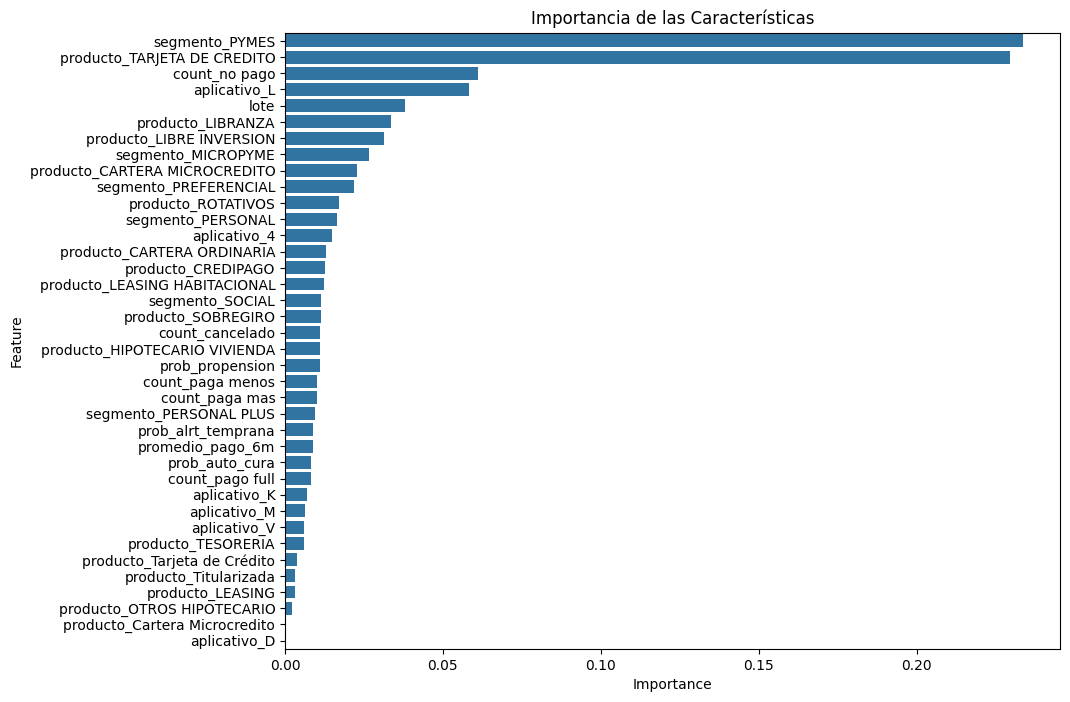

In [24]:
import seaborn as sns

import matplotlib.pyplot as plt

# Obtener las importancias de las características
importances = best_xgb_model.feature_importances_

# Crear un DataFrame para facilitar la visualización
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar las características por importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Visualizar las importancias de las características
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Importancia de las Características')
plt.show()

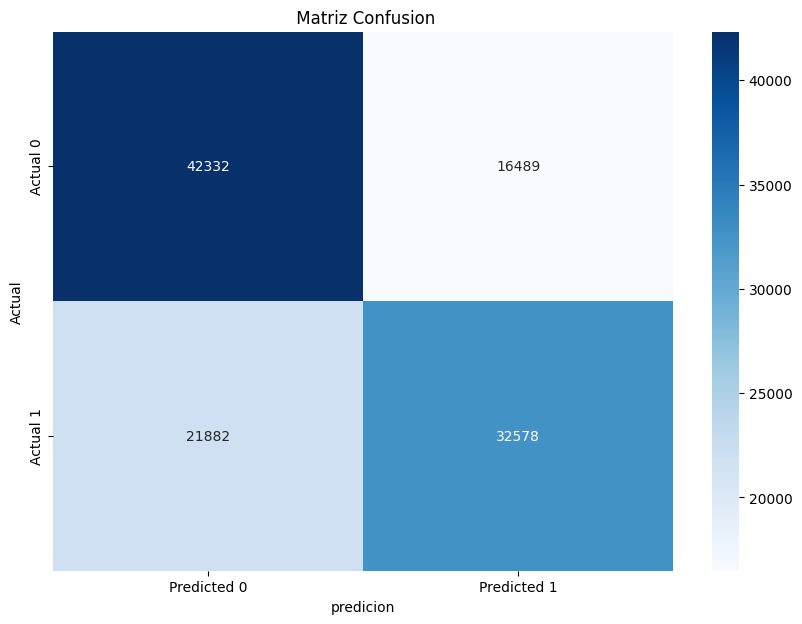

In [29]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear un heatmap para la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('predicion')
plt.ylabel('Actual')
plt.title(' Matriz Confusion')
plt.show()

<module 'matplotlib.pyplot' from 'c:\\Program Files\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

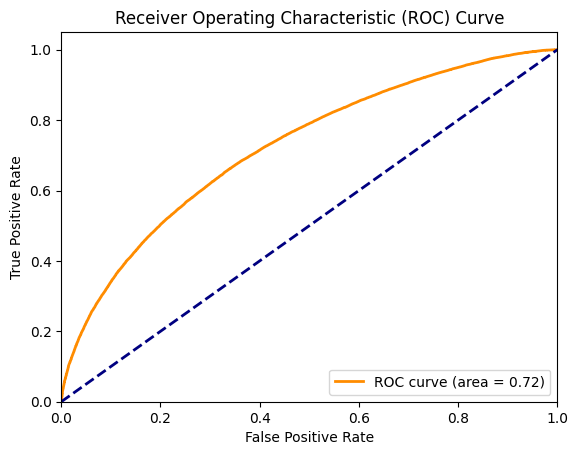

In [25]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Pintar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt

In [26]:
prueba = pd.read_csv('../data/prueba_op_base_pivot_var_rpta_alt_enmascarado_oot.csv')

In [27]:
#x=model.predict(df)

In [28]:
df_cuotas = pd.read_csv('../data/prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv')
df_cuotas = df_cuotas[['nit_enmascarado', 'num_oblig_enmascarado', 'fecha_corte','producto','aplicativo','segmento','valor_cuota_mes','pago_total','marca_pago']]
df_cuotas['fecha_corte'] = pd.to_datetime(df_cuotas['fecha_corte'], format='%Y%m%d', errors='coerce')

prueba_final = pd.merge(prueba, df_cuotas, how='left', on=['nit_enmascarado', 'num_oblig_enmascarado'])
prueba_final['fecha_var_rpta_alt'] = pd.to_datetime(prueba_final['fecha_var_rpta_alt'], format='%Y%m', errors='coerce')


In [29]:
distinct_oblig = prueba.drop_duplicates(subset=['num_oblig_enmascarado', 'nit_enmascarado','fecha_var_rpta_alt']).shape[0]
print("Número de combinaciones únicas de obligación y nit:", distinct_oblig)

Número de combinaciones únicas de obligación y nit: 112499


In [30]:
distinct_oblig = prueba_final.drop_duplicates(subset=['num_oblig_enmascarado', 'nit_enmascarado','fecha_var_rpta_alt']).shape[0]
print("Número de combinaciones únicas de obligación y nit:", distinct_oblig)

Número de combinaciones únicas de obligación y nit: 112499


In [31]:

def clasificar_marca_pago(row):
    total = row['valor_cuota_mes']
    pago = row['pago_total']
    
    # Si el valor total es 0, sin importar el pago, se clasifica como "cancelado"
    if total == 0:
        return 'cancelado'
    else:
        # Si hay un valor total (diferente de 0):
        if pago == 0:
            return 'no pago'
        elif pago > total:
            return 'paga mas'
        elif pago < total:
            return 'paga menos'
        elif pago == total:
            return 'pago full'
        else:
            return ''

# Aplicar la función a cada fila de dataset
prueba_final['marca_pago2'] = prueba_final.apply(clasificar_marca_pago, axis=1)



# --- Paso 1: Ordenar por fechas ---
prueba_final = prueba_final.sort_values(['nit_enmascarado', 'num_oblig_enmascarado', 'fecha_corte'])

# --- Paso 2: Calcular el ratio de pago (para referencia, luego se descarta) ---
prueba_final['ratio_pago'] = prueba_final['pago_total'] / prueba_final['valor_cuota_mes']
prueba_final['ratio_pago'] = prueba_final['ratio_pago'].fillna(0)


In [32]:
# --- Paso 3: Seleccionar los últimos 6 registros para cada obligación ---
df_last6 = prueba_final.groupby(['nit_enmascarado', 'num_oblig_enmascarado','fecha_var_rpta_alt'], as_index=False).tail(6)

# --- Paso 4: Crear la variable binaria a partir de 'marca_pago2' ---
def binarizar_pago(marca):
    # Convertir a minúsculas para evitar problemas de mayúsculas/minúsculas
    if isinstance(marca, str) and marca.lower() in ['pago full', 'paga mas']:
        return 1
    else:
        return 0

df_last6['pago_binario'] = df_last6['marca_pago2'].apply(binarizar_pago)

C:\Users\alejreye\AppData\Local\Temp\ipykernel_40304\753862292.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last6['pago_binario'] = df_last6['marca_pago2'].apply(binarizar_pago)


In [33]:

# Calcular el promedio del indicador binario en los últimos 6 registros para cada obligación
agg_binario = df_last6.groupby(['nit_enmascarado', 'num_oblig_enmascarado'], as_index=False)['pago_binario'].mean()
agg_binario.rename(columns={'pago_binario': 'promedio_pago_6m'}, inplace=True)

# --- Paso 5: Calcular el conteo de ocurrencias de cada categoría en 'marca_pago2' para los últimos 6 registros ---
marca_pago_counts = df_last6.groupby(
    ['nit_enmascarado', 'num_oblig_enmascarado']
)['marca_pago2'].value_counts().unstack(fill_value=0).reset_index()

# Renombrar columnas (las dos primeras son las llaves, el resto son las categorías)
cols = marca_pago_counts.columns.tolist()
new_cols = cols[:2] + [f'count_{col}' for col in cols[2:]]
marca_pago_counts.columns = new_cols

# --- Paso 6: Fusionar las métricas históricas con el DataFrame original ---
# Primero, fusionar el promedio binario (promedio_pago_6m)
prueba_final = pd.merge(
    prueba_final,
    agg_binario,
    on=['nit_enmascarado', 'num_oblig_enmascarado'],
    how='left'
)


In [34]:

# Luego, fusionar los conteos de 'marca_pago2'
prueba_final = pd.merge(
    prueba_final,
    marca_pago_counts,
    on=['nit_enmascarado', 'num_oblig_enmascarado'],
    how='left'
)


In [35]:
# --- Paso 7: Eliminar columnas que ya no se requieren ---
prueba_final = prueba_final.drop(columns=['valor_cuota_mes', 'pago_total', 'marca_pago', 'marca_pago2', 'ratio_pago'])

# --- Paso 8: Ordenar por 'nit_enmascarado' y 'fecha_corte' (descendente) y conservar el registro más reciente por cliente ---
prueba_final = prueba_final.sort_values(['nit_enmascarado', 'fecha_corte'], ascending=[True, False])

In [36]:
prueba_final = prueba_final.drop_duplicates(subset=['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_alt'], keep='first')

In [37]:
prueba_final1 = pd.merge(prueba, prueba_final, how='left', on=['nit_enmascarado', 'num_oblig_enmascarado'])
prueba_final1 = prueba_final1.rename(columns={'num_oblig_orig_enmascarado_x': 'num_oblig_orig_enmascarado'})


In [38]:
# Calcular la moda de cada columna
mode_producto = prueba_final1['producto'].mode()[0]
mode_segmento = prueba_final1['segmento'].mode()[0]

# Llenar los valores nulos con la moda
prueba_final1['producto'].fillna(mode_producto, inplace=True)
prueba_final1['segmento'].fillna(mode_segmento, inplace=True)

C:\Users\alejreye\AppData\Local\Temp\ipykernel_40304\1592663666.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prueba_final1['producto'].fillna(mode_producto, inplace=True)
C:\Users\alejreye\AppData\Local\Temp\ipykernel_40304\1592663666.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

In [39]:
prueba_final1=prueba_final1.drop(columns=['fecha_corte','fecha_var_rpta_alt_y','count_', 'num_oblig_orig_enmascarado_y'])

In [40]:
#Analisis de df_prob
df_prob['prob_alrt_temprana'] = pd.to_numeric(df_prob['prob_alrt_temprana'], errors='coerce')
df_prob['prob_auto_cura'] = pd.to_numeric(df_prob['prob_auto_cura'], errors='coerce')
df_prob['prob_propension'] = pd.to_numeric(df_prob['prob_propension'], errors='coerce')
prueba_final1 = pd.merge(prueba_final1, df_prob, how='left', on=['nit_enmascarado', 'num_oblig_enmascarado'])
prueba_final1['fecha_var_rpta_alt_x'] = pd.to_datetime(prueba_final1['fecha_var_rpta_alt_x'], format='%Y%m', errors='coerce')



In [41]:
prueba_final1 = prueba_final1.sort_values(['nit_enmascarado', 'fecha_corte'], ascending=[True, False])
prueba_final1 = prueba_final1.drop_duplicates(subset=['nit_enmascarado','num_oblig_enmascarado','fecha_var_rpta_alt_x'], keep='first')

In [42]:
prueba_final1 = pd.merge(prueba, prueba_final1, how='left', on=['nit_enmascarado', 'num_oblig_enmascarado'])


In [43]:
# Calcular la mediana de cada columna con valores numéricos
lote_propension = prueba_final1['lote'].median()
median_propension = prueba_final1['prob_propension'].median()
median_alrt_temprana = prueba_final1['prob_alrt_temprana'].median()
median_auto_cura = prueba_final1['prob_auto_cura'].median()

# Rellenar los valores nulos con la mediana correspondiente
prueba_final1['lote'] = prueba_final1['lote'].fillna(lote_propension)
prueba_final1['prob_propension'] = prueba_final1['prob_propension'].fillna(median_propension)
prueba_final1['prob_alrt_temprana'] = prueba_final1['prob_alrt_temprana'].fillna(median_alrt_temprana)
prueba_final1['prob_auto_cura'] = prueba_final1['prob_auto_cura'].fillna(median_auto_cura)

mode_aplicativo = prueba_final1['aplicativo'].mode()[0]

# Llenar los valores nulos con la moda
prueba_final1['aplicativo'].fillna(mode_producto, inplace=True)

C:\Users\alejreye\AppData\Local\Temp\ipykernel_40304\3191243534.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prueba_final1['aplicativo'].fillna(mode_producto, inplace=True)


In [44]:
prueba_final1=prueba_final1.drop(columns=['fecha_corte','fecha_var_rpta_alt_x'])

In [45]:
prueba_final1 = pd.get_dummies(prueba_final1, columns=['producto','aplicativo','segmento'], drop_first=True)

In [ ]:
# Lista de features que el modelo espera (orden EXACTO)
expected_features = best_xgb_model.get_booster().feature_names

for col in expected_features:
    if col not in prueba_final1.columns:
        prueba_final1[col] = 0

# Reordenar las columnas para que coincidan exactamente con expected_features.
X_pred = prueba_final1[expected_features]

# Verificar la lista de columnas en X_pred
print("Columnas en X_pred:", list(X_pred.columns))

# Ahora se procede a predecir
y_pred = best_xgb_model.predict(X_pred)          
y_pred_proba = best_xgb_model.predict_proba(X_pred)[:, 1]

# Agregar las predicciones al DataFrame de prueba_final1
prueba_final1["var_rpta_alt_pred"] = y_pred
prueba_final1["var_rpta_alt_prob"] = y_pred_proba

Columnas en X_pred: ['promedio_pago_6m', 'count_cancelado', 'count_no pago', 'count_paga mas', 'count_paga menos', 'count_pago full', 'lote', 'prob_propension', 'prob_alrt_temprana', 'prob_auto_cura', 'producto_CARTERA MICROCREDITO', 'producto_CARTERA ORDINARIA', 'producto_CREDIPAGO', 'producto_Cartera Microcredito', 'producto_HIPOTECARIO VIVIENDA', 'producto_LEASING', 'producto_LEASING HABITACIONAL', 'producto_LIBRANZA', 'producto_LIBRE INVERSION', 'producto_OTROS HIPOTECARIO', 'producto_ROTATIVOS', 'producto_SOBREGIRO', 'producto_TARJETA DE CREDITO', 'producto_TESORERIA', 'producto_Tarjeta de Crédito', 'producto_Titularizada', 'aplicativo_4', 'aplicativo_D', 'aplicativo_K', 'aplicativo_L', 'aplicativo_M', 'aplicativo_V', 'segmento_MICROPYME', 'segmento_PERSONAL', 'segmento_PERSONAL PLUS', 'segmento_PREFERENCIAL', 'segmento_PYMES', 'segmento_SOCIAL']


In [49]:
prueba_final1["ID"] = (
    prueba_final1["nit_enmascarado"].astype(str) + "#" +
    prueba_final1["num_oblig_orig_enmascarado_x"].astype(str) + "#" +
    prueba_final1["num_oblig_enmascarado"].astype(str)
)
submission = prueba_final1[["ID", "var_rpta_alt_pred"]]
submission.columns = ["ID", "var_rpta_alt"]
submission.to_csv("submission.csv", index=False)
